In [1]:
import torch
import copy
import matplotlib.pyplot as plt

## Training an MLP


The previous linear regression example was a joke. Let us get slightly more serious!




### Dataset

In [2]:
nx = 1 # single input
ny = 1 # single output
a = -1 # lower limit x
b = 1 # higher limit x
n_samples = 100 # data point
sigma_e = 0.1 # noise std
lr = 1e-3 # learning rage

In [3]:
# Function definition
def f(x):
    return 2*torch.sin(3*x)  - 3*torch.cos(7*x)

In [4]:
# Generate synthetic data
x_train = a + torch.rand((n_samples, 1))*(b - a)
y_train = f(x_train) + sigma_e * torch.randn(n_samples, 1)
y_train = y_train.view(-1, 1)
x_train.shape, y_train.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

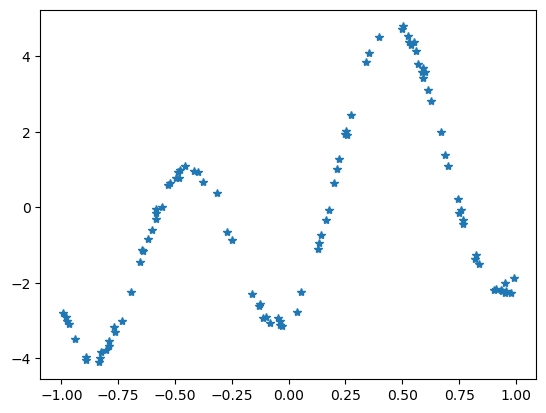

In [5]:
plt.plot(x_train, y_train, "*");

### Model

We model the data with a MLP with one hidden layer with 16 hidden nodes:
\begin{gather}
f: \mathbb{R} \rightarrow \mathbb{R} := W_2 \tanh (W_1 x + b_1) + b_2 \\
\end{gather}

with 
\begin{equation}
W_1 \in \mathbb{R}^{16 \times 1}, b_1 \in \mathbb{R}^{16}, W_2 \in \mathbb{R}^{1 \times 16}, b_2 \in \mathbb{R}^{1}
\end{equation}

In [6]:
n_hidden = 16
params_init = {
    "W1": torch.randn(n_hidden, nx, requires_grad=True),
    "b1": torch.randn(n_hidden, requires_grad=True),
    "W2": torch.randn(ny, n_hidden, requires_grad=True),
    "b2": torch.randn(ny, requires_grad=True)
}

def nn(params, x):
    z = torch.tanh(params["W1"] @ x + params["b1"])
    y = params["W2"] @ z + params["b2"]
    return y

In [7]:
# The nn function above works for a single input x, but cannot handle a "batch"
nn(params_init, x_train[0]) 
#nn(params_init, x_train) 

tensor([-7.4332], grad_fn=<AddBackward0>)

In [8]:
# We can "vectorize" the nn function with linear algebra and broadcasting tricks
def batched_nn(params, x):
    z = torch.sigmoid(x @ params["W1"].T + params["b1"])
    y = z @ params["W2"].T + params["b2"]
    return y

In [9]:
# The recently introduced vmap transform simplifies vectorization
# batched_nn = torch.func.vmap(nn, in_dims=(None, 0))

In [10]:
batched_nn(params_init, x_train).shape

torch.Size([100, 1])

### Visualize the MLP model  at initialization together with the data points

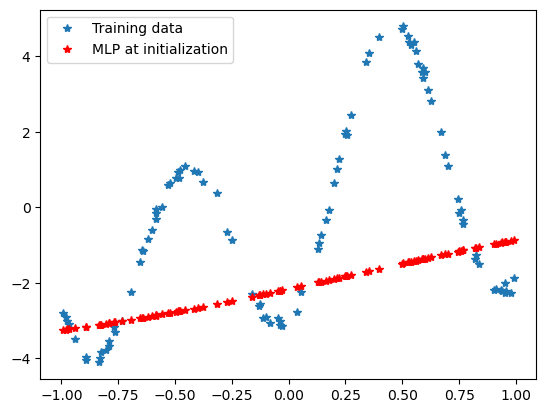

In [11]:
plt.figure()
plt.plot(x_train, y_train, "*", label="Training data")
plt.plot(x_train, batched_nn(params_init, x_train).detach(), "r*", label="MLP at initialization")
plt.legend();

### Train the MLP  by minimizing the MSE loss on the training dataset with gradient descent

Hint: 
* You can use ``torch.autograd.grad`` to compute the gradients. The second argument can be a list of variables, you get back a list of derivatives
* Alternatively, you can call ``loss.backward``. After the call to backward, each parameter `p` will have a `p.grad` field containing the gradient. Free the .grad field after usage with `p.grad.zero_()`, otherwise, gradients are accumulated over iterations!

In [12]:
# this works, but it is annoying...
y_hat = batched_nn(params_init, x_train)
loss = torch.mean((y_train - y_hat)**2)
grad_W1, grad_b1, grad_W2, grad_b2 = torch.autograd.grad(loss, (params_init["W1"], params_init["b1"], params_init["W2"], params_init["b2"]))

In [13]:
y_hat = batched_nn(params_init, x_train)
loss = torch.mean((y_train - y_hat)**2)
loss.backward()
params_init["W1"].grad # each parameter has a .grad attribute which, after calling backward, contains the derivative

tensor([[-0.2359],
        [ 0.0473],
        [-0.2749],
        [-0.0562],
        [-0.0935],
        [ 0.1033],
        [ 0.3230],
        [-0.0782],
        [-0.0638],
        [ 0.0089],
        [ 0.0293],
        [ 0.2575],
        [-0.0236],
        [ 0.0923],
        [ 0.1012],
        [ 0.0862]])

In [14]:
LOSS = []
lr = 0.1
iters = 10_000
params_opt = copy.deepcopy(params_init)
for _ in range(iters):
    y_hat = batched_nn(params_init, x_train)
    loss = torch.mean((y_train - y_hat)**2)
    loss.backward()
    for p in params_init.values():
        p.data -= lr * p.grad
        p.grad.zero_() # set p.grad to zero, otherwise gradients get accumulated over iterations
    LOSS.append(loss.item())

### Visualize the training loss

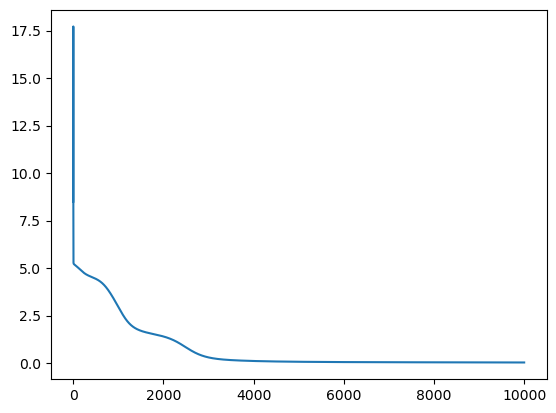

In [15]:
plt.figure()
plt.plot(LOSS);

### Visualize the trained MLP model  and the data points

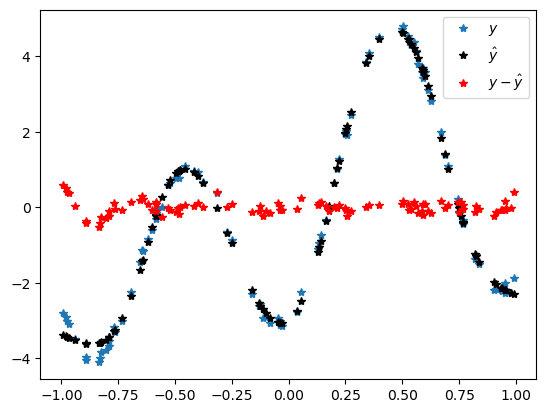

In [16]:
with torch.no_grad():
    y_hat = batched_nn(params_init, x_train)

plt.figure()
plt.plot(x_train, y_train, "*", label="$y$")
plt.plot(x_train, y_hat, "k*", label=r"$\hat y$")
plt.plot(x_train, y_train - y_hat, "r*", label=r"$y - \hat y$")
plt.legend();


### Bonus

Can you compute the loss derivatives analytically and/or  verify some of them numerically (eg, by finite differences)?